Accuracy (SVM): 52.95%


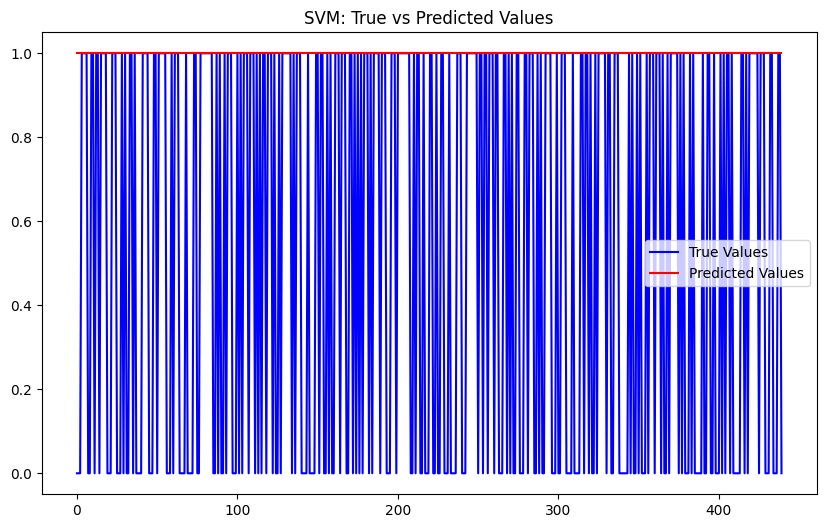

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('transformed_data.csv')
data_class = data.copy()

# Konwersja kolumny 'LogReturn' na klasy (1 dla wzrostu, 0 dla spadku)
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)
data_class['date'] = pd.to_datetime(data_class['date'])

# Filtrujemy dane z lat < 2019
data_class = data_class.loc[data_class['date'].dt.year < 2019]

# Przygotowanie cech i zmiennej celu
X = data_class.drop(['LogReturn', 'date'], axis=1)
Y = data_class['LogReturn']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Inicjalizacja i trenowanie modelu SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred_svm = svm_model.predict(X_test)

# Ocena dokładności
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True Values", color='blue')
plt.plot(y_pred_svm, label="Predicted Values", color='red')
plt.title('SVM: True vs Predicted Values')
plt.legend()
plt.show()


Accuracy (SVM): 79.77%


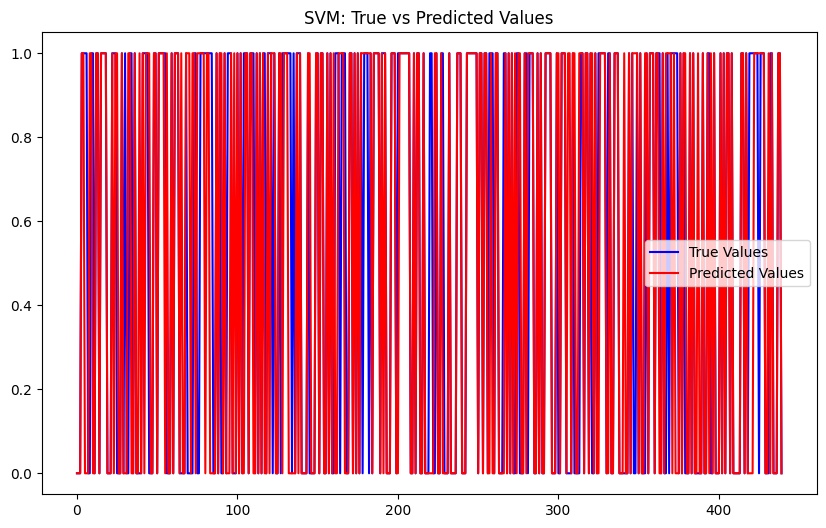

In [2]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('transformed_data.csv')
data_class = data.copy()

# Konwersja kolumny 'LogReturn' na klasy (1 dla wzrostu, 0 dla spadku)
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)
data_class['date'] = pd.to_datetime(data_class['date'])

# Filtrujemy dane z lat < 2019
data_class = data_class.loc[data_class['date'].dt.year < 2019]

# Przygotowanie cech i zmiennej celu
X = data_class.drop(['LogReturn', 'date'], axis=1)
Y = data_class['LogReturn']

# Skaling danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Obliczenie wag klas (ważniejsze klasy dostaną większe wagi)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Inicjalizacja i trenowanie modelu SVM z wagami klas
svm_model = SVC(kernel='rbf', C=1, gamma='scale', class_weight=class_weight_dict, random_state=42)
svm_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred_svm = svm_model.predict(X_test)

# Ocena dokładności
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True Values", color='blue')
plt.plot(y_pred_svm, label="Predicted Values", color='red')
plt.title('SVM: True vs Predicted Values')
plt.legend()
plt.show()


Najlepsze parametry: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Dokładność po optymalizacji: 80.23%


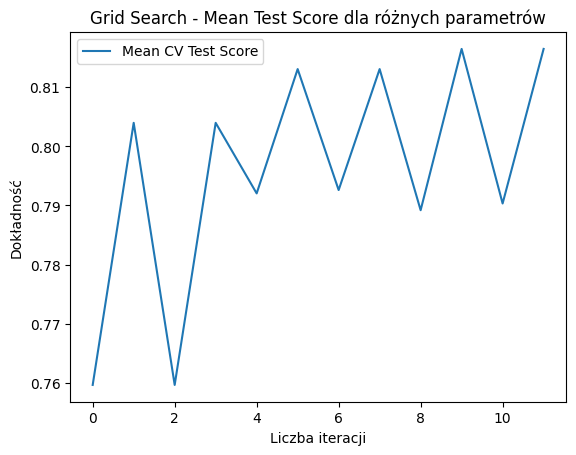

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('transformed_data.csv')
data_class = data.copy()

# Tworzenie zmiennej binarnej na podstawie 'LogReturn'
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)

# Konwersja daty na datetime
data_class['date'] = pd.to_datetime(data_class['date'])

# Selekcja danych przed 2019 rokiem
data_class = data_class.loc[data_class['date'].dt.year < 2019]

# Przygotowanie cech
X = data_class.drop(['LogReturn', 'date'], axis=1)
Y = data_class['LogReturn']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Skalowanie cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Obliczenie wag klas (ważniejsze klasy dostaną większe wagi)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Definicja parametrów dla GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Inicjalizacja i przeprowadzenie GridSearchCV
grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_scaled, y_train)

# Wybór najlepszego modelu
best_model = grid_search.best_estimator_

print(f"Najlepsze parametry: {grid_search.best_params_}")

# Predykcja na zbiorze testowym
X_test_scaled = scaler.transform(X_test)
y_pred = best_model.predict(X_test_scaled)

# Obliczenie dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność po optymalizacji: {accuracy * 100:.2f}%")

# Wizualizacja wyników
plt.plot(grid_search.cv_results_['mean_test_score'], label="Mean CV Test Score")
plt.title("Grid Search - Mean Test Score dla różnych parametrów")
plt.xlabel("Liczba iteracji")
plt.ylabel("Dokładność")
plt.legend()
plt.show()
